In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from datetime import datetime


In [2]:
dataset = pd.read_csv('Walmart_dataset_modificado.csv')
dataset.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,08-01-2010,1425307.565,0,41.97,2.420,211.081890,7.545
1,1,15-01-2010,1360899.630,0,49.08,2.473,210.997826,7.545
2,1,22-01-2010,1346232.857,0,47.33,2.496,210.925603,7.545
3,1,29-01-2010,1318112.450,0,49.05,2.549,211.023576,7.545
4,1,05-02-2010,1643690.900,0,42.31,2.572,211.096358,8.106


In [3]:
df = pd.DataFrame({'Fecha': dataset['Date'],'Ventas': dataset['Weekly_Sales'], 'Holiday_Flag': dataset['Holiday_Flag'], 'Temperature': dataset['Temperature'], 'Fuel_Price': dataset['Fuel_Price'], 'CPI': dataset['CPI'], 'Unemployment': dataset['Unemployment']  }) 
df.head()

,Fecha,Ventas,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,08-01-2010,1425307.565,0,41.97,2.420,211.081890,7.545
1,15-01-2010,1360899.630,0,49.08,2.473,210.997826,7.545
2,22-01-2010,1346232.857,0,47.33,2.496,210.925603,7.545
3,29-01-2010,1318112.450,0,49.05,2.549,211.023576,7.545
4,05-02-2010,1643690.900,0,42.31,2.572,211.096358,8.106


In [4]:
df["Fecha"] = pd.to_datetime(df["Fecha"], format='%d-%m-%Y')

In [5]:
df["Fecha"] = df['Fecha'].dt.strftime('%Y-%m-%d')
print(df)

          Fecha       Ventas  Holiday_Flag  Temperature  Fuel_Price  \
0    2010-01-08  1425307.565             0       41.970       2.420   
1    2010-01-15  1360899.630             0       49.080       2.473   
2    2010-01-22  1346232.857             0       47.330       2.496   
3    2010-01-29  1318112.450             0       49.050       2.549   
4    2010-02-05  1643690.900             0       42.310       2.572   
..          ...          ...           ...          ...         ...   
151  2012-11-30  1620134.120             0       49.090       3.582   
152  2012-12-07  1916750.510             0       49.090       3.580   
153  2012-12-14  1871318.410             0       45.130       3.592   
154  2012-12-21  2152427.780             0       50.735       3.588   
155  2012-12-28  1627605.430             1       50.145       3.586   

            CPI  Unemployment  
0    211.081890         7.545  
1    210.997826         7.545  
2    210.925603         7.545  
3    211.023576    

In [6]:
df['Fecha'] = pd.to_datetime(df['Fecha'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Fecha         156 non-null    datetime64[ns]
 1   Ventas        156 non-null    float64       
 2   Holiday_Flag  156 non-null    int64         
 3   Temperature   156 non-null    float64       
 4   Fuel_Price    156 non-null    float64       
 5   CPI           156 non-null    float64       
 6   Unemployment  156 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 8.7 KB


In [8]:
df.set_index('Fecha', inplace=True)

In [9]:
df.head()

,Ventas,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Fecha,,,,,,
2010-01-08,1425307.565,0,41.97,2.420,211.081890,7.545
2010-01-15,1360899.630,0,49.08,2.473,210.997826,7.545
2010-01-22,1346232.857,0,47.33,2.496,210.925603,7.545
2010-01-29,1318112.450,0,49.05,2.549,211.023576,7.545
2010-02-05,1643690.900,0,42.31,2.572,211.096358,8.106


In [10]:
len(df)

156

In [11]:
df.to_csv('WalmartLSTM.csv')

In [12]:
len(df)

156

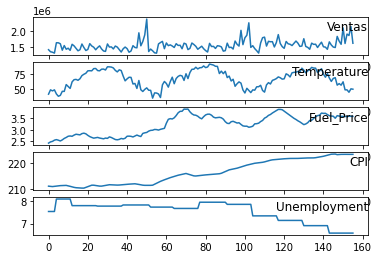

In [13]:
from pandas import read_csv
from matplotlib import pyplot

# load dataset
dataset = read_csv('WalmartLSTM.csv', index_col=0)
values = dataset.values

# specify columns to plot
groups = [0, 2, 3, 4, 5]
i = 1

# plot each column
pyplot.figure()
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

In [14]:
len(dataset)

156

In [15]:
len(values)

156

In [16]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
   cols.append(df.shift(i))
 names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
   cols.append(df.shift(-i))
 if i == 0:
   names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
 else:
   names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
   agg.dropna(inplace=True)
 return agg

In [17]:
len(dataset)

156

In [18]:
len(values)

156

In [19]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.101217        0.0   0.116800   0.000000   0.056799   0.634051  0.041081
2   0.041081        0.0   0.243200   0.035642   0.050386   0.634051  0.027388
3   0.027388        0.0   0.212089   0.051110   0.044874   0.634051  0.001133
4   0.001133        0.0   0.242667   0.086752   0.052351   0.634051  0.305113
5   0.305113        0.0   0.122844   0.102219   0.057903   1.000000  0.303495


In [20]:
len(dataset)

156

In [21]:
len(values)

156

In [22]:
len(scaled)

156

In [23]:
len(reframed)

155

In [24]:
# split into train and test sets
values = reframed.values
train = values[:-30]
test = values[-30: ]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(125, 1, 6) (125,) (30, 1, 6) (30,)


In [25]:
len(values)

155

Epoch 1/100
2/2 - 6s - loss: 0.0634 - val_loss: 0.1003 - 6s/epoch - 3s/step
Epoch 2/100
2/2 - 0s - loss: 0.0558 - val_loss: 0.0900 - 79ms/epoch - 39ms/step
Epoch 3/100
2/2 - 0s - loss: 0.0491 - val_loss: 0.0805 - 79ms/epoch - 39ms/step
Epoch 4/100
2/2 - 0s - loss: 0.0432 - val_loss: 0.0720 - 71ms/epoch - 35ms/step
Epoch 5/100
2/2 - 0s - loss: 0.0381 - val_loss: 0.0643 - 94ms/epoch - 47ms/step
Epoch 6/100
2/2 - 0s - loss: 0.0338 - val_loss: 0.0576 - 95ms/epoch - 47ms/step
Epoch 7/100
2/2 - 0s - loss: 0.0303 - val_loss: 0.0518 - 96ms/epoch - 48ms/step
Epoch 8/100
2/2 - 0s - loss: 0.0275 - val_loss: 0.0468 - 77ms/epoch - 38ms/step
Epoch 9/100
2/2 - 0s - loss: 0.0254 - val_loss: 0.0427 - 79ms/epoch - 39ms/step
Epoch 10/100
2/2 - 0s - loss: 0.0239 - val_loss: 0.0394 - 79ms/epoch - 39ms/step
Epoch 11/100
2/2 - 0s - loss: 0.0229 - val_loss: 0.0368 - 79ms/epoch - 39ms/step
Epoch 12/100
2/2 - 0s - loss: 0.0224 - val_loss: 0.0348 - 79ms/epoch - 39ms/step
Epoch 13/100
2/2 - 0s - loss: 0.0222 - va

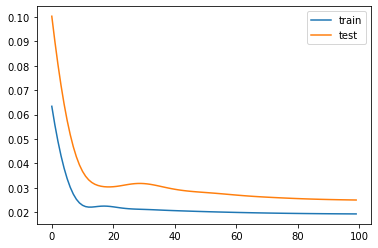

In [26]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11451 (44.73 KB)
Trainable params: 11451 (44.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

1/1 [==============================] - 1s 1s/step
Test RMSE: 169560.007


In [29]:
dataset.head()

,Ventas,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Fecha,,,,,,
2010-01-08,1425307.565,0,41.97,2.420,211.081890,7.545
2010-01-15,1360899.630,0,49.08,2.473,210.997826,7.545
2010-01-22,1346232.857,0,47.33,2.496,210.925603,7.545
2010-01-29,1318112.450,0,49.05,2.549,211.023576,7.545
2010-02-05,1643690.900,0,42.31,2.572,211.096358,8.106


In [30]:
dataset_reset = dataset.reset_index()

In [31]:
dataset_reset.head()

,Fecha,Ventas,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,2010-01-08,1425307.565,0,41.97,2.420,211.081890,7.545
1,2010-01-15,1360899.630,0,49.08,2.473,210.997826,7.545
2,2010-01-22,1346232.857,0,47.33,2.496,210.925603,7.545
3,2010-01-29,1318112.450,0,49.05,2.549,211.023576,7.545
4,2010-02-05,1643690.900,0,42.31,2.572,211.096358,8.106


In [32]:
resultados = pd.DataFrame(data={'Prediccion':inv_yhat, 'Test': inv_y })
resultados.head()
len(resultados)

30

In [33]:
len(train)

125

In [34]:
len(inv_yhat)

30

In [35]:
dataset_fecha = dataset_reset.Fecha[-30:]
len(dataset_fecha)

30

In [36]:
predicciones = pd.DataFrame(data={'Fecha':dataset_fecha, 'Prediccion':inv_yhat, 'Test': inv_y })
predicciones.head()
#len(predicciones)

,Fecha,Prediccion,Test
126,2012-06-08,1590612.750,1697231.000
127,2012-06-15,1603313.000,1630607.000
128,2012-06-22,1588260.625,1527845.750
129,2012-06-29,1570836.750,1540421.500
130,2012-07-06,1560300.250,1769854.125


In [37]:
predicciones_test = pd.DataFrame(data={'Fecha':dataset_fecha, 'Prediccion':inv_yhat })
predicciones_test.head()
#len(predicciones)

,Fecha,Prediccion
126,2012-06-08,1590612.750
127,2012-06-15,1603313.000
128,2012-06-22,1588260.625
129,2012-06-29,1570836.750
130,2012-07-06,1560300.250


In [38]:
predicciones_test['Fecha'] = pd.to_datetime(predicciones_test['Fecha'])

In [39]:
predicciones_test.info()
predicciones_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 126 to 155
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Fecha       30 non-null     datetime64[ns]
 1   Prediccion  30 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 492.0 bytes


,Fecha,Prediccion
126,2012-06-08,1590612.750
127,2012-06-15,1603313.000
128,2012-06-22,1588260.625
129,2012-06-29,1570836.750
130,2012-07-06,1560300.250


In [40]:
predicciones_test.set_index('Fecha', inplace=True)

In [41]:
df.head()

,Ventas,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Fecha,,,,,,
2010-01-08,1425307.565,0,41.97,2.420,211.081890,7.545
2010-01-15,1360899.630,0,49.08,2.473,210.997826,7.545
2010-01-22,1346232.857,0,47.33,2.496,210.925603,7.545
2010-01-29,1318112.450,0,49.05,2.549,211.023576,7.545
2010-02-05,1643690.900,0,42.31,2.572,211.096358,8.106


In [42]:
predicciones_test.head()

,Prediccion
Fecha,
2012-06-08,1590612.750
2012-06-15,1603313.000
2012-06-22,1588260.625
2012-06-29,1570836.750
2012-07-06,1560300.250


In [43]:
predicciones_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2012-06-08 to 2012-12-28
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Prediccion  30 non-null     float32
dtypes: float32(1)
memory usage: 360.0 bytes


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 2010-01-08 to 2012-12-28
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ventas        156 non-null    float64
 1   Holiday_Flag  156 non-null    int64  
 2   Temperature   156 non-null    float64
 3   Fuel_Price    156 non-null    float64
 4   CPI           156 non-null    float64
 5   Unemployment  156 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 8.5 KB


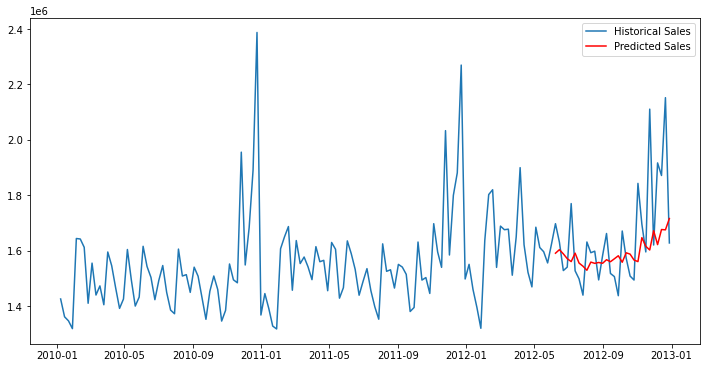

In [45]:
# plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(df.Ventas, label='Historical Sales')
#plt.plot(trainPredictPlot, color='red')
plt.plot(predicciones_test, label='Predicted Sales', color='red')
#plt.title('Predicciones del Modelo LSTM')
plt.legend()
plt.show()

In [46]:
#Calculo del error del modelo: RMSE (evaluate forecasts)
rmse = sqrt(mean_squared_error(inv_yhat,  inv_y ))
print('Test RMSE: %.3f' % rmse)

#Calculo del error cuadratico medio del modelo: MSE (evaluate forecasts)
mse = mean_squared_error(inv_yhat,  inv_y)
print('Test MSE: %.3f' % mse)

#Calculo del error absoluto medio del modelo: MAE (evaluate forecasts)
mae = mean_absolute_error(inv_yhat,  inv_y)
print('Test MAE: %.3f' % mae)

#Calculo del error porcentual Absoluto Medio del modelo: MAPE (evaluate forecasts)
mape = mean_absolute_percentage_error(inv_yhat,  inv_y)
print('Test MAPE: %.3f' % mape)


Test RMSE: 169560.007
Test MSE: 28750596096.000
Test MAE: 117589.000
Test MAPE: 0.073
